<a href="https://colab.research.google.com/github/huyhoang17/Colab_Temporary/blob/master/[Training]Semantic_Search_TinyImageNet_10epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cat /proc/meminfo

MemTotal:       13335212 kB
MemFree:        11271372 kB
MemAvailable:   12643772 kB
Buffers:           43660 kB
Cached:          1503972 kB
SwapCached:            0 kB
Active:           522616 kB
Inactive:        1317940 kB
Active(anon):     271252 kB
Inactive(anon):      336 kB
Active(file):     251364 kB
Inactive(file):  1317604 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              6044 kB
Writeback:             0 kB
AnonPages:        292916 kB
Mapped:           169468 kB
Shmem:               844 kB
Slab:             119344 kB
SReclaimable:      90184 kB
SUnreclaim:        29160 kB
KernelStack:        4064 kB
PageTables:         4908 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667604 kB
Committed_AS:    1920040 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [3]:
import sys
from sys import getsizeof
import os
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import logging
import os
import json
import time

import numpy as np

from keras import optimizers
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.losses import cosine_proximity, sparse_categorical_crossentropy
from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

logger = logging.getLogger()
logger.setLevel(logging.INFO)

Using TensorFlow backend.


In [0]:
import cv2

In [5]:
!ls drive/My\ Drive/workspace/Semantic_Search/models

checkpoint.hdf5        id2vectors_100D.pkl  image_mapping.pkl
final_image_index.ann  id2words.pkl	    test
id2labels_cleaned.pkl  id_labels.pkl	    word_index.ann
id2labels.pkl	       image_index_v2.ann   words.pkl
id2path_images.pkl     image_index_v3.ann   wv_label_mapping.pkl


In [5]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -P drive/My\ Drive/workspace/Semantic_Search/data


Redirecting output to ‘wget-log’.


In [0]:
# https://tiny-imagenet.herokuapp.com/

In [6]:
!ls drive/My\ Drive/workspace/Semantic_Search/data

tiny-imagenet-200  tiny-imagenet-200.zip


In [0]:
import time
from functools import wraps

def timer(func):

    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print("- Function {} tooks {}'s".format(func.__name__, end - start))
        return result

    return wrapper

In [0]:
# !rm -rf drive/My\ Drive/workspace/Semantic_Search/data/tiny-imagenet-200

In [0]:
# import shutil

# shutil.rmtree('drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200')

In [0]:
# !unzip drive/My\ Drive/workspace/Semantic_Search/data/tiny-imagenet-200.zip -d drive/My\ Drive/workspace/Semantic_Search/data

Archive:  drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200.zip
replace drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/words.txt  
  inflating: drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/wnids.txt  


In [0]:
# @timer
# def extract_data():
#     import zipfile
#     zip_ref = zipfile.ZipFile('drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200.zip', 'r')
#     zip_ref.extractall('drive/My Drive/workspace/Semantic_Search/data')
#     zip_ref.close()
    
# extract_data()

In [8]:
!ls drive/My\ Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train | wc -l 

200


In [0]:
id_labels = os.listdir('drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/')

In [10]:
print(id_labels)

['n03584254', 'n02403003', 'n02056570', 'n02769748', 'n01443537', 'n02129165', 'n02814533', 'n04259630', 'n01774750', 'n02410509', 'n09332890', 'n03796401', 'n04562935', 'n04532106', 'n03617480', 'n02917067', 'n07583066', 'n06596364', 'n02892201', 'n02206856', 'n04376876', 'n03838899', 'n02125311', 'n04456115', 'n02837789', 'n09428293', 'n02124075', 'n02113799', 'n03160309', 'n07871810', 'n01698640', 'n07753592', 'n02999410', 'n12267677', 'n02788148', 'n04371430', 'n01910747', 'n09193705', 'n04008634', 'n03424325', 'n03085013', 'n03250847', 'n03891332', 'n03014705', 'n07579787', 'n03355925', 'n07920052', 'n03544143', 'n04399382', 'n03599486', 'n07768694', 'n02165456', 'n02099601', 'n09256479', 'n03854065', 'n04133789', 'n07720875', 'n04070727', 'n04486054', 'n03814639', 'n02415577', 'n02802426', 'n04146614', 'n03733131', 'n04311004', 'n02927161', 'n02883205', 'n04560804', 'n02950826', 'n03662601', 'n03770439', 'n02793495', 'n07873807', 'n03444034', 'n01882714', 'n02058221', 'n02791270'

In [11]:
id_labels.sort()
print(id_labels)

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684'

In [0]:
import pickle
with open('drive/My Drive/workspace/Semantic_Search/models/id_labels.pkl', 'wb') as f:
  pickle.dump(id_labels, f)

In [12]:
len(id_labels)

200

In [0]:
tiny_path = 'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/wnids.txt'
word_path = 'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/words.txt'
total_labels = {}
with open(word_path) as f:
  for line in f:
    id_, label = line.strip().split('\t')
    total_labels[id_] = label

In [14]:
len(total_labels)

82115

In [18]:
total_labels['n04540053']

'volleyball'

In [0]:
with open(tiny_path) as f:
  labels_mapping = {}
  for line in f:
    line = line.strip()
    if line in total_labels:
      labels_mapping[line] = total_labels[line]

In [20]:
len(labels_mapping)

200

In [21]:
for i, (key, value) in enumerate(labels_mapping.items()):
  print(key, value)
  if i == 10:
    break

n02124075 Egyptian cat
n04067472 reel
n04540053 volleyball
n04099969 rocking chair, rocker
n07749582 lemon
n01641577 bullfrog, Rana catesbeiana
n02802426 basketball
n09246464 cliff, drop, drop-off
n07920052 espresso
n03970156 plunger, plumber's helper
n03891332 parking meter


In [0]:
labels_mapping = dict(sorted(labels_mapping.items()))

In [17]:
for i, (key, value) in enumerate(labels_mapping.items()):
  print(key, value)
  if i == 10:
    break

n01443537 goldfish, Carassius auratus
n01629819 European fire salamander, Salamandra salamandra
n01641577 bullfrog, Rana catesbeiana
n01644900 tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
n01698640 American alligator, Alligator mississipiensis
n01742172 boa constrictor, Constrictor constrictor
n01768244 trilobite
n01770393 scorpion
n01774384 black widow, Latrodectus mactans
n01774750 tarantula
n01784675 centipede


In [0]:
import pickle
with open('drive/My Drive/workspace/Semantic_Search/models/id2labels.pkl', 'wb') as f:
  pickle.dump(labels_mapping, f)

In [0]:
import pickle
with open('drive/My Drive/workspace/Semantic_Search/models/id2labels.pkl', 'rb') as f:
  labels_mapping = pickle.load(f)

In [14]:
os.path.exists('drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/n04540053/images/n04540053_499.JPEG')

True

In [15]:
os.path.exists('drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/n03599486/images/n03599486_499.JPEG')

True

In [0]:

import random

def show_imgs(id_folder):
  fmt = 'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'
  random_imgs = [fmt.format(id_folder, id_folder, num) for num in random.sample(range(0, 500), 9)]
  fig = plt.figure(figsize=(8, 8))
  columns = 3
  rows = 3
  for i in range(1, columns*rows +1):
      img = mpimg.imread(random_imgs[i - 1])
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

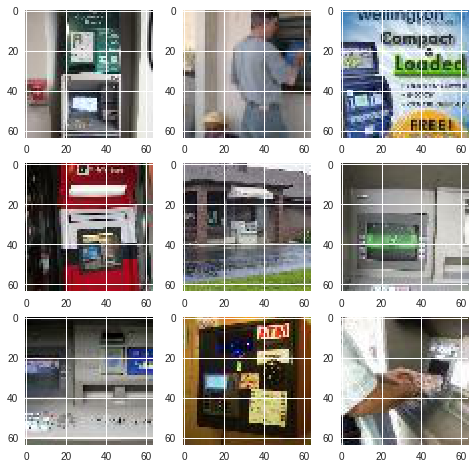

In [13]:
show_imgs('n02977058')

In [0]:
labels_mapping

In [0]:
import string  # noqa
def remove_punctuation(text):
    """https://stackoverflow.com/a/37221663"""
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table)

In [0]:
labels_map_cleanup = {}
for key, value in labels_mapping.items():
  labels = list(set([label.lower() for label in remove_punctuation(value).split()]))
  labels_map_cleanup[key] = labels

In [0]:
labels_map_cleanup

In [0]:
with open('drive/My Drive/workspace/Semantic_Search/models/id2labels_cleaned.pkl', 'wb') as f:
  pickle.dump(labels_map_cleanup, f)

In [0]:
with open('drive/My Drive/workspace/Semantic_Search/models/id2labels_cleaned.pkl', 'rb') as f:
  labels_map_cleanup = pickle.load(f)

In [0]:
def load_glove_vectors(glove_dir, glove_name='glove.6B.100d.txt'):
    """
    Mostly from keras docs here https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
    Download GloVe vectors here http://nlp.stanford.edu/data/glove.6B.zip
    :param glove_name: name of pre-trained file
    :param glove_dir: directory in witch the glove file is located
    :return:
    """
    f = open(os.path.join(glove_dir, glove_name))
    embeddings_index = {}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [19]:
word_vectors = load_glove_vectors("drive/My Drive/workspace/Semantic_Search/glove")

Found 400000 word vectors.


In [20]:
len(word_vectors), type(word_vectors)

(400000, dict)

In [21]:
word_vectors['cat'].shape

(100,)

In [22]:
word_vectors['seacoast']

array([-0.38194  ,  0.43988  ,  0.58552  , -0.034747 , -0.50875  ,
        0.38016  , -0.021186 , -0.069807 , -0.30524  ,  0.56016  ,
       -0.39408  , -0.72094  , -0.26261  , -0.27321  ,  0.29538  ,
       -0.44681  ,  0.77011  , -0.43178  , -0.02412  , -0.39597  ,
        0.0048259,  0.48248  , -0.042813 , -0.020684 , -0.17532  ,
       -0.034594 , -0.13539  , -0.0051166, -0.92901  , -0.4429   ,
       -0.062894 , -0.20222  ,  0.37766  , -0.43097  ,  0.18253  ,
       -0.23389  , -0.0027962, -0.42943  ,  0.70313  ,  0.36277  ,
       -0.072662 ,  0.37953  , -0.24078  ,  0.554    , -0.027632 ,
        0.15297  ,  0.4621   ,  0.43635  ,  0.52693  ,  0.70875  ,
       -0.13994  ,  0.7485   ,  0.22864  , -0.26292  ,  0.31093  ,
       -0.22231  ,  0.02618  , -0.64931  , -0.38589  , -0.13484  ,
       -0.090415 ,  0.12118  ,  0.25469  , -0.025956 , -0.15474  ,
        0.21892  , -0.24454  ,  0.21641  , -0.10835  , -0.48227  ,
       -0.12174  , -0.26497  ,  1.2933   , -0.23517  , -0.4216

In [23]:
word_vectors['sea-coast']

array([ 0.18082  , -0.089967 ,  0.088731 ,  0.22664  ,  0.22301  ,
       -0.22277  , -0.073979 , -0.013792 ,  0.007327 ,  0.10245  ,
       -0.04797  ,  0.091218 ,  0.06451  ,  0.0052649,  0.33744  ,
        0.11993  , -0.401    , -0.05329  ,  0.12112  , -0.55241  ,
       -0.29004  ,  0.024582 , -0.22211  , -0.50237  , -0.21662  ,
       -0.23027  ,  0.52515  ,  0.37444  , -0.11972  , -0.12956  ,
        0.20512  , -0.36148  ,  0.32304  , -0.16029  ,  0.028747 ,
       -0.37177  ,  0.32291  , -0.38384  ,  0.18961  ,  0.30357  ,
        0.11672  , -0.082055 ,  0.041996 ,  0.39386  ,  0.15626  ,
        0.17847  , -0.030812 ,  0.27453  ,  0.39666  ,  0.31633  ,
        0.15832  ,  0.62267  , -0.31715  , -0.53404  ,  0.032422 ,
        0.82122  ,  0.11129  , -0.38983  , -0.029134 , -0.25287  ,
       -0.0049469, -0.22122  ,  0.14722  , -0.18117  , -0.14078  ,
        0.1469   , -0.77571  , -0.52495  , -0.37573  ,  0.021631 ,
        0.067198 ,  0.037177 ,  0.5658   ,  0.18958  , -0.1635

In [0]:
def load_paired_img_wrd(labels_map_cleanup):
  wv_label_mapping = {}
  for key, value in labels_map_cleanup.items():
    vectors = np.array([word_vectors[label] if label in word_vectors else np.zeros(shape=100) for label in value])
    class_vector = np.mean(vectors, axis=0)
    wv_label_mapping[key] = class_vector
  return wv_label_mapping

In [0]:
wv_label_mapping = load_paired_img_wrd(labels_map_cleanup)

In [0]:
import pickle
with open('drive/My Drive/workspace/Semantic_Search/models/id2vectors_100D.pkl', 'wb') as f:
  pickle.dump(wv_label_mapping, f)

In [0]:
import pickle
with open('drive/My Drive/workspace/Semantic_Search/models/id2vectors_100D.pkl', 'rb') as f:
  wv_label_mapping= pickle.load(f)

In [0]:
# from google.colab import files
# files.download('drive/My Drive/workspace/Semantic_Search/models/wv_label_mapping.pkl') 

### Indexing images using Annoy

In [0]:
def load_headless_pretrained_model():
    """
    Loads the pretrained version of VGG with the last layer cut off
    :return: pre-trained headless VGG16 Keras Model
    """
    pretrained_vgg16 = VGG16(weights='imagenet',include_top=True)
    model = Model(inputs=pretrained_vgg16.input,
                  outputs=pretrained_vgg16.get_layer('fc2').output)
    return model

In [0]:
from tqdm import tqdm
def generate_features(id_labels, model):
    """
    Takes in an array of image paths, and a trained model.
    Returns the activations of the last layer for each image
    :param image_paths: array of image paths
    :param model: pre-trained model
    :return: array of last-layer activations, and mapping from array_index to file_path
    """
    base_train = 'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train'
    for folder in tqdm(id_labels):
      label_path = os.path.join(base_train, folder, 'images')
      fn_paths = sorted(os.listdir(label_path))
      fn_paths = [os.path.join(label_path, fn_path) for fn_path in fn_paths]
      for fn_path in fn_paths:
        img = image.load_img(fn_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        input_ = preprocess_input(img)
        feature = model.predict(input_)
        
        yield feature, fn_path

In [0]:
def build_image_mapping(id_labels):
    """
    Takes in an array of image paths, and a trained model.
    Returns the activations of the last layer for each image
    :param image_paths: array of image paths
    :param model: pre-trained model
    :return: array of last-layer activations, and mapping from array_index to file_path
    """
    base_train = 'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train'
    i = 0
    images_mapping = {}
    for folder in tqdm(id_labels):
      label_path = os.path.join(base_train, folder, 'images')
      fn_paths = sorted(os.listdir(label_path))
      fn_paths = [os.path.join(label_path, fn_path) for fn_path in fn_paths]
      for fn_path in fn_paths:
        images_mapping[i] = fn_path
        i += 1
    return images_mapping

In [0]:
import pickle
with open('drive/My Drive/workspace/Semantic_Search/models/image_mapping.pkl', 'rb') as f:
  image_mapping = pickle.load(f)

In [30]:
len(image_mapping)

100000

In [31]:
model = load_headless_pretrained_model()

553467904/553467096 [==============================] - 6s 0us/step


In [0]:
# images_features_gen = generate_features(wv_label_mapping, model)

In [32]:
wv_label_mapping.keys()

dict_keys(['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', '

In [0]:
@timer
def index_features(features, n_trees=1000, dims=4096, is_dict=False):
    """
    Use Annoy to index our features to be able to query them rapidly
    :param features: array of item features
    :param n_trees: number of trees to use for Annoy. Higher is more precise but slower.
    :param dims: dimension of our features
    :return: an Annoy tree of indexed features
    """
    feature_index = AnnoyIndex(dims, metric='angular')
    for i, row in enumerate(features):
        vec = row
        if is_dict:
            vec = features[row]
        feature_index.add_item(i, vec[0][0])
    feature_index.build(n_trees)
    return feature_index

In [0]:
def extract_feat(self, img_path):
    img = image.load_img(img_path, target_size=(self.input_shape[0], self.input_shape[1]))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feat = self.model.predict(img)
    norm_feat = feat[0]/LA.norm(feat[0])
    return norm_feat

In [35]:
!pip install annoy

    100% |████████████████████████████████| 634kB 5.9MB/s 
  Running setup.py bdist_wheel for annoy ... - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/96/af/26/f26df0a684b1e41ad8c56a13fc13e7a0a15a8a1a8b1cb0111a
Successfully built annoy


In [0]:
from annoy import AnnoyIndex

In [0]:
# uploaded = drive.CreateFile({'title': 'image_index_v2.ann'})
# uploaded.SetContentFile('drive/My Drive/workspace/Semantic_Search/models/image_index_v2.ann')
# uploaded.Upload()

In [0]:
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [68]:
# Build Image Index
# image_index = index_features(images_features_gen)

100%|██████████| 200/200 [49:49<00:00, 15.14s/it]


- Function index_features tooks 4440.546419620514's


In [83]:
# Save Image Index
# image_index.save('drive/My Drive/workspace/Semantic_Search/models/image_index_v3.ann')

True

In [0]:
image_index = AnnoyIndex(4096, metric='angular')
image_index.load('drive/My Drive/workspace/Semantic_Search/models/image_index_v2.ann')

In [56]:
image_index.get_n_items()

100000

In [0]:
words = list(word_vectors.keys())

In [0]:
import pickle
with open('drive/My Drive/workspace/Semantic_Search/models/words.pkl', 'wb') as f:
  pickle.dump(words, f)

In [0]:
def index_word_features(features, n_trees=20, dims=100, is_dict=False):
    """
    Use Annoy to index our features to be able to query them rapidly
    :param features: array of item features
    :param n_trees: number of trees to use for Annoy. Higher is more precise but slower.
    :param dims: dimensio
    n of our features
    :return: an Annoy tree of indexed features
    """
    feature_index = AnnoyIndex(dims, metric='angular')
    for i, row in enumerate(features):
        if i == 1000:
            print(i)
        vec = row
        if is_dict:
            vec = features[row]
        # vec.shape = (100, )
        feature_index.add_item(i, vec)
        # import pdb; pdb.set_trace()
    feature_index.build(n_trees)
    return feature_index

In [0]:
def build_word_mapping(word_vectors):
    """
    Builds a fast index out of a list of pretrained word vectors
    :param word_vectors: a list of pre-trained word vectors loaded from a file
    :return: an Annoy tree of indexed word vectors and a mapping from the Annoy index to the word string
    """
    logging.info("Creating mapping and list of features")
    word_list = [(i, word) for i, word in enumerate(word_vectors)]
    word_mapping = {k: v for k, v in word_list}
    return word_mapping

In [0]:
def generated_word_features(word_vectors):
  for _, value in word_vectors.items():
    yield value

In [40]:
word_mapping = build_word_mapping(word_vectors)
# word_index = index_word_features(generated_word_features(word_vectors))
# with open('drive/My Drive/workspace/Semantic_Search/models/id2words.pkl', 'wb') as f:
#   pickle.dump(word_mapping, f)

# files.download('drive/My Drive/workspace/Semantic_Search/models/id2words.pkl')
# word_index.save('drive/My Drive/workspace/Semantic_Search/models/word_index.ann')
# files.download('drive/My Drive/workspace/Semantic_Search/models/words_index.ann') 

INFO:root:Creating mapping and list of features


In [62]:
word_index = AnnoyIndex(100, metric='angular')
word_index.load('drive/My Drive/workspace/Semantic_Search/models/word_index.ann')
word_index.get_n_items()

400000

In [0]:
def search_index_by_key(key, feature_index, item_mapping, top_n=10):
    """
    Search an Annoy index by key, return n nearest items
    :param key: the index of items
    :param feature_index: an Annoy tree of indexed features
    :param item_mapping: mapping from indices to paths/names
    :param top_n: how many items to return
    :return: an array of [index, item, distance] of size top_n
    """
    distances = feature_index.get_nns_by_item(key, top_n, include_distances=True)
    return [[a, item_mapping[a], distances[1][i]] for i, a in enumerate(distances[0])]

In [0]:
out = search_index_by_key(100, word_index, word_mapping, 10)
out2 = search_index_by_key(200, word_index, word_mapping, 10)
out3 = search_index_by_key(300, word_index, word_mapping, 10)

In [0]:
out

In [0]:
out2

In [0]:
out3

In [0]:
out = search_index_by_key(400, word_index, word_mapping, 10)
out2 = search_index_by_key(500, word_index, word_mapping, 10)
out3 = search_index_by_key(600, word_index, word_mapping, 10)

In [0]:
out, out2, out3

In [0]:
import matplotlib.image as mpimg

def show_sim_imgs(search_key):
    
    results = search_index_by_key(search_key, image_index, image_mapping, 10)
  
    main_img = mpimg.imread(results[0][1])
    plt.imshow(main_img)
    fig = plt.figure(figsize=(16, 16))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        img = mpimg.imread(results[i][1])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

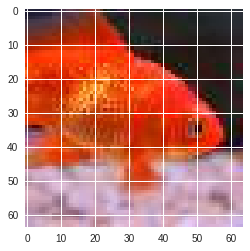

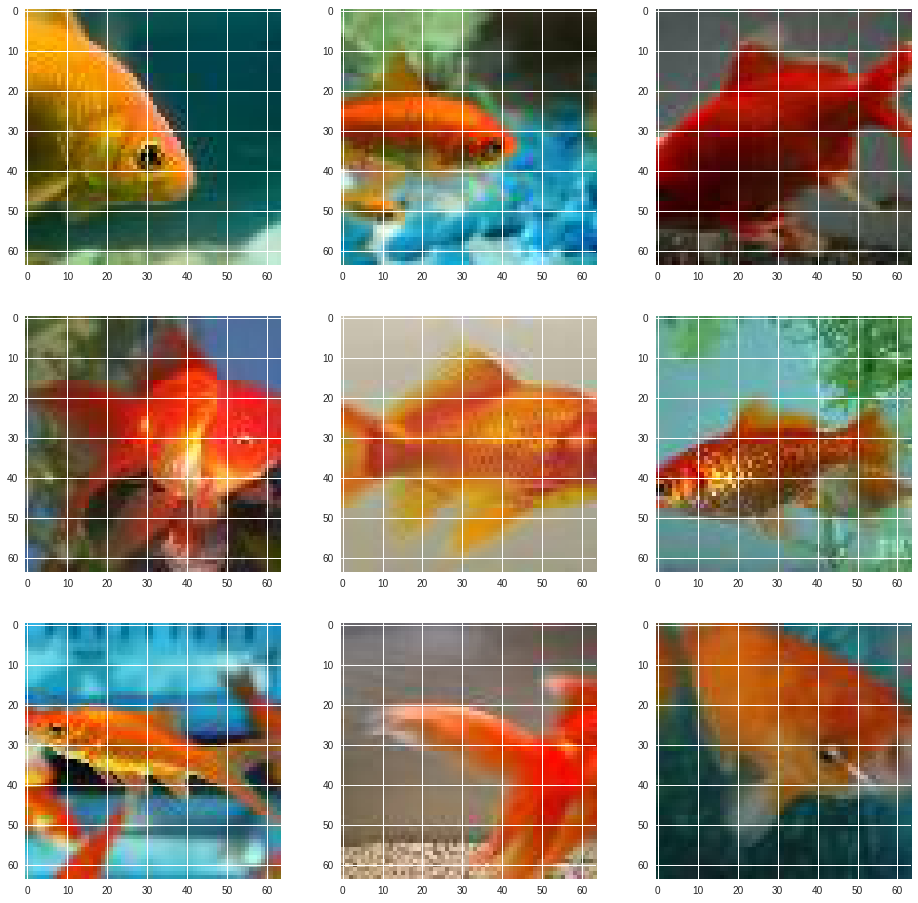

In [49]:
show_sim_imgs(100)

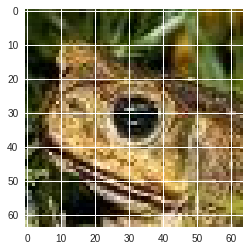

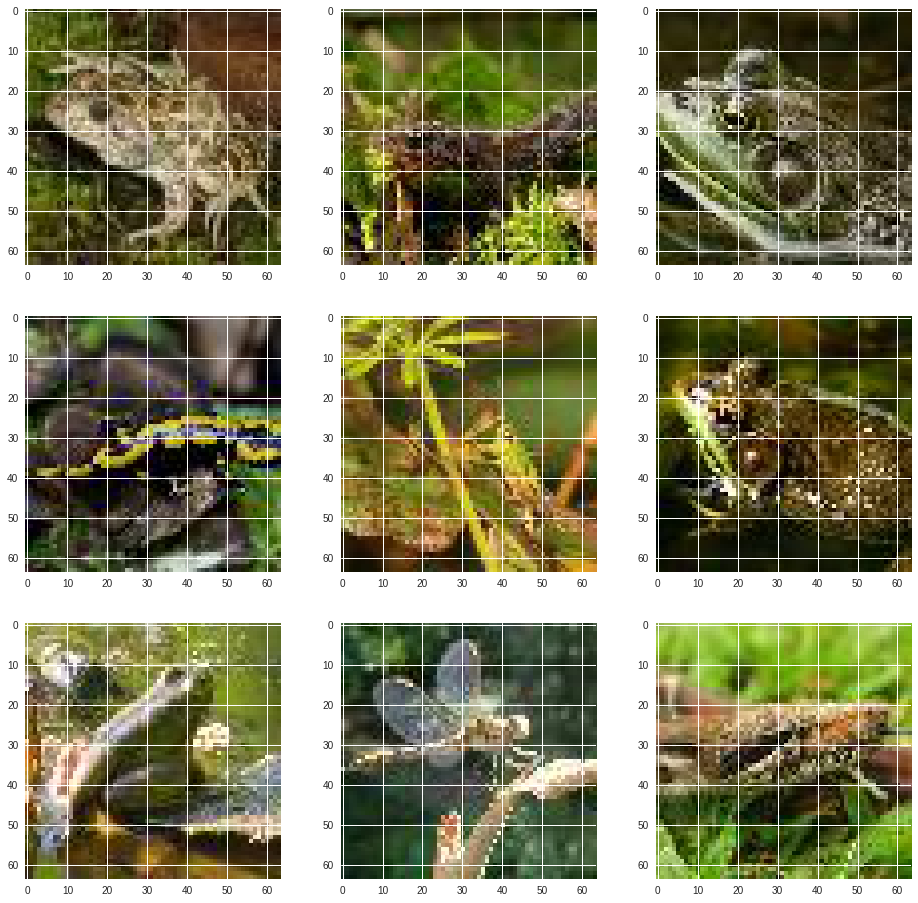

In [51]:
show_sim_imgs(1500)

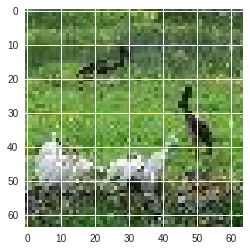

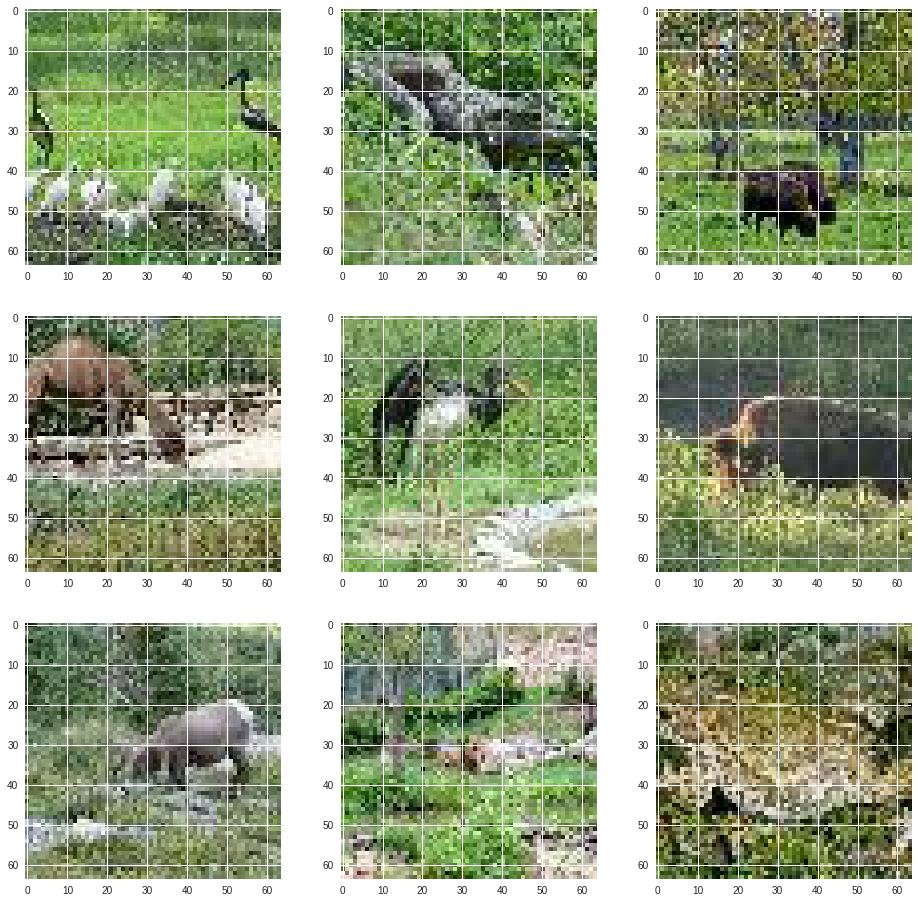

In [53]:
show_sim_imgs(10000)

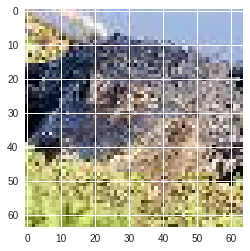

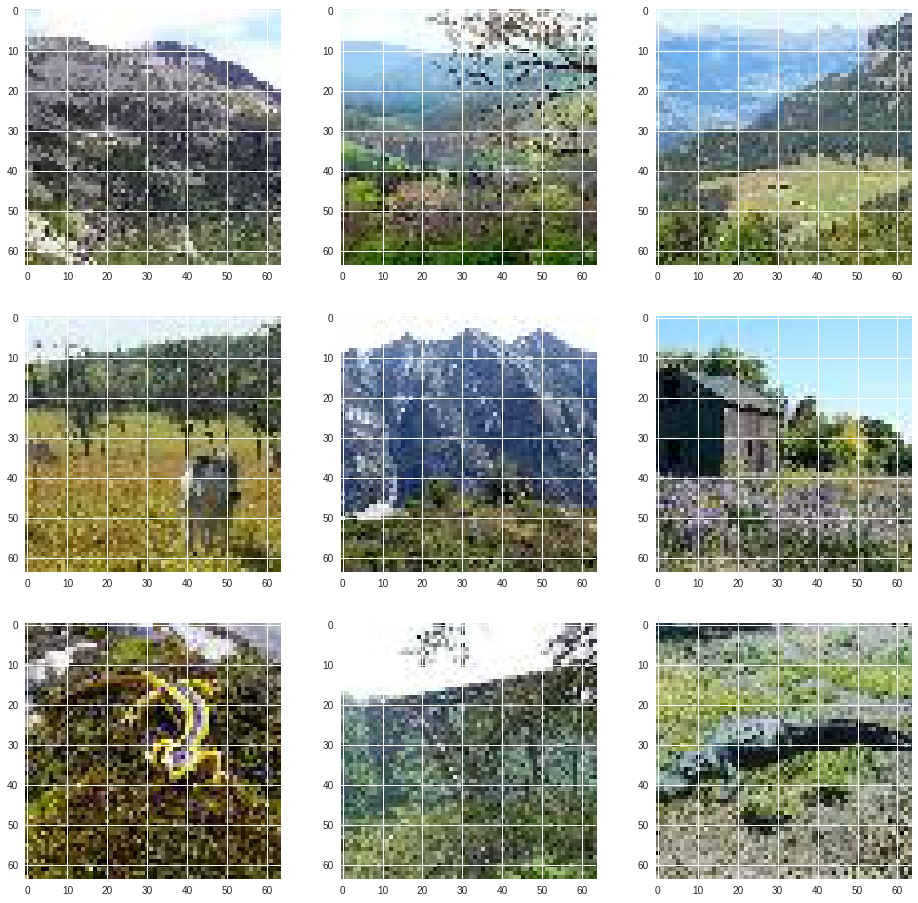

In [52]:
show_sim_imgs(2000)

In [0]:
results = search_index_by_key(10000, image_index, image_mapping, 10)

In [54]:
results

[[10000,
  'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/n02002724/images/n02002724_0.JPEG',
  0.0],
 [10222,
  'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/n02002724/images/n02002724_299.JPEG',
  0.34021201729774475],
 [1190,
  'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/n01641577/images/n01641577_27.JPEG',
  0.40879160165786743],
 [25119,
  'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/n02410509/images/n02410509_205.JPEG',
  0.4376932680606842],
 [26811,
  'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/n02437312/images/n02437312_379.JPEG',
  0.4552645683288574],
 [10455,
  'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/n02002724/images/n02002724_59.JPEG',
  0.4648616909980774],
 [25328,
  'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train/n02410509/images/n02410509_394.JPEG',
  0.46552619338035583],
 [25567,
  'driv

In [0]:
# import pickle
# with open('drive/My Drive/workspace/Semantic_Search/models/image_mapping.pkl', 'wb') as f:
#   pickle.dump(image_mapping, f)

In [0]:
def setup_custom_model(intermediate_dim=2000, word_embedding_dim=100):
    """
    Builds a custom model taking the fc2 layer of VGG16 and adding two dense layers on top
    :param intermediate_dim: dimension of the intermediate dense layer
    :param word_embedding_dim: dimension of the final layer, which should match the size of our word embeddings
    :return: a Keras model with the backbone frozen, and the upper layers ready to be trained
    """
    headless_pretrained_vgg16 = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    x = headless_pretrained_vgg16.get_layer('fc2').output

    # We do not re-train VGG entirely here, just to get to a result quicker (fine-tuning the whole network would
    # lead to better results)
    for layer in headless_pretrained_vgg16.layers:
        layer.trainable = False

    image_dense1 = Dense(intermediate_dim, name="image_dense1")(x)
    image_dense1 = BatchNormalization()(image_dense1)
    image_dense1 = Activation("relu")(image_dense1)
    image_dense1 = Dropout(0.5)(image_dense1)

    image_dense2 = Dense(word_embedding_dim, name="image_dense2")(image_dense1)
    image_dense2 = BatchNormalization()(image_dense2)

    complete_model = Model(inputs=[headless_pretrained_vgg16.input], outputs=image_dense2)
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    complete_model.compile(optimizer=sgd, loss=cosine_proximity)
    return complete_model

In [0]:
custom_model = setup_custom_model()

In [43]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [44]:
custom_model.input, custom_model.output

(<tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'batch_normalization_2/cond/Merge:0' shape=(?, 100) dtype=float32>)

In [0]:
import keras
from tqdm import tqdm 
class TextSequenceGenerator(keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, mode="train", batch_size=16,
                 img_size=(224, 224), no_channels=3, shuffle=True):
        # train 95, test 5
        self.imgs, self.labels = [], []
        self.mode = mode
        if self.mode == "train":
          self.imgs = list(image_mapping.values())
#           base_train = 'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train'
#           for folder in tqdm(id_labels):
#             label_path = os.path.join(base_train, folder, 'images')
#             fn_paths = sorted(os.listdir(label_path))
#             for fn_path in fn_paths:
#               self.imgs.append(os.path.join(label_path, fn_path))
#               self.labels.append(folder)
          for i in tqdm(range(200)):
            for j in range(500):
              self.labels.append(id_labels[i])
        elif self.mode == "val":
          base_val = 'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/val'
          with open('drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/val/val_annotations.txt') as f:
            for line in f:
              fn_path = os.path.join(base_val, "images", line.split('\t')[0])
              id_label = line.split('\t')[1]
              self.imgs.append(fn_path)
              self.labels.append(id_label)

        self.ids = range(len(self.imgs))

        self.img_size = img_size
        self.img_w, self.img_h = self.img_size
        self.batch_size = batch_size
        self.no_channels = no_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        indexes = self.indexes[index *
                               self.batch_size:(index + 1) * self.batch_size]

        ids = [self.ids[k] for k in indexes]

        X, y = self.__data_generation(ids)
        
        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, ids):
        size = len(ids)

        X = np.empty(
            (size, self.img_w, self.img_h, self.no_channels),
            dtype=np.float32
        )
        Y = np.empty((size, 100), dtype=np.float32)

        # import pdb; pdb.set_trace()
        for i, id_ in enumerate(ids):
#             img = image.load_img(self.imgs[id_], target_size=(224, 224))
#             img = image.img_to_array(img)
#             img = np.expand_dims(img, axis=0)
#             img = preprocess_input(img)
            img = cv2.imread(self.imgs[id_])
            img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
            img = img / 255
            X[i, ] = img
            Y[i] = wv_label_mapping[self.labels[id_]]
        return X, Y

In [0]:
# imgs, labels = [], []
# base_train = 'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train'
# for folder in tqdm(id_labels):
#   label_path = os.path.join(base_train, folder, 'images')
#   fn_paths = sorted(os.listdir(label_path))
#   import pdb; pdb.set_trace()
#   for fn_path in fn_paths:
#     imgs.append(os.path.join(label_path, fn_path))
#     labels.append(folder)

In [46]:
from keras.callbacks import ModelCheckpoint


num_epochs = 10
batch_size = 16
logging.info(
    "Training for %s epochs, this might take a while, "
    "change train_model to False to load pre-trained model", num_epochs)

data_generator = TextSequenceGenerator(mode="train", batch_size=batch_size, shuffle=True)
val_data_generator = TextSequenceGenerator(mode="val", batch_size=batch_size, shuffle=False)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/workspace/Semantic_Search/models/checkpoint2.hdf5', verbose=1, save_best_only=True)
custom_model.fit_generator(data_generator, steps_per_epoch=100000//batch_size,
                 epochs=num_epochs, 
                 validation_data=val_data_generator, validation_steps=10000//batch_size,
                           callbacks=[checkpointer])
# custom_model.save(model_save_path)
model_json = custom_model.to_json()
with open('drive/My Drive/workspace/Semantic_Search/models/config.json', 'w') as f:
    f.write(model_json)

custom_model.save_weights('drive/My Drive/workspace/Semantic_Search/models/best_model.hdf5')

INFO:root:Training for 10 epochs, this might take a while, change train_model to False to load pre-trained model
100%|██████████| 200/200 [00:00<00:00, 7992.73it/s]


Epoch 1/10
6250/6250 [==============================] - 24786s 4s/step - loss: -0.4183 - val_loss: -0.4956

Epoch 00001: val_loss improved from inf to -0.49555, saving model to drive/My Drive/workspace/Semantic_Search/models/checkpoint2.hdf5
Epoch 2/10
6250/6250 [==============================] - 1262s 202ms/step - loss: -0.4849 - val_loss: -0.5031

Epoch 00002: val_loss improved from -0.49555 to -0.50315, saving model to drive/My Drive/workspace/Semantic_Search/models/checkpoint2.hdf5
Epoch 3/10
6250/6250 [==============================] - 1260s 202ms/step - loss: -0.4931 - val_loss: -0.5087

Epoch 00003: val_loss improved from -0.50315 to -0.50865, saving model to drive/My Drive/workspace/Semantic_Search/models/checkpoint2.hdf5
Epoch 4/10
6250/6250 [==============================] - 1260s 202ms/step - loss: -0.4985 - val_loss: -0.5151

Epoch 00004: val_loss improved from -0.50865 to -0.51506, saving model to drive/My Drive/workspace/Semantic_Search/models/checkpoint2.hdf5
Epoch 5/10


In [47]:
uploaded = drive.CreateFile({'title': 'config.json'})
uploaded.SetContentFile('drive/My Drive/workspace/Semantic_Search/models/config.json')
uploaded.Upload()

uploaded = drive.CreateFile({'title': 'best_model.hdf5'})
uploaded.SetContentFile('drive/My Drive/workspace/Semantic_Search/models/best_model.hdf5')
uploaded.Upload()

uploaded = drive.CreateFile({'title': 'checkpoint.hdf5'})
uploaded.SetContentFile('drive/My Drive/workspace/Semantic_Search/models/checkpoint.hdf5')
uploaded.Upload()

AttributeError: ignored

In [0]:
# from keras.callbacks import ModelCheckpoint


# num_epochs = 200
# batch_size = 16
# logging.info(
#     "Training for %s epochs, this might take a while, "
#     "change train_model to False to load pre-trained model", num_epochs)
# data_generator = gen_data(id_labels, wv_label_mapping)
# val_data_generator = gen_val_data(base_val, wv_label_mapping)
# checkpointer = ModelCheckpoint(filepath='drive/My Drive/workspace/Semantic_Search/models/checkpoint.hdf5', verbose=1, save_best_only=True)
# custom_model.fit(X_train, y_train, validation_data=(X_test, y_test),
#                      epochs=num_epochs, batch_size=batch_size, callbacks=[checkpointer])
# # custom_model.save(model_save_path)
# model_json = custom_model.to_json()
# with open('drive/My Drive/workspace/Semantic_Search/models/config.json', 'w') as f:
#     f.write(model_json)

# custom_model.save_weights('drive/My Drive/workspace/Semantic_Search/models/best_model.hdf5')

In [0]:
base_train = 'drive/My Drive/workspace/Semantic_Search/data/tiny-imagenet-200/train'
imgs = []
labels = []
for folder in tqdm(id_labels):
  label_path = os.path.join(base_train, folder, 'images')
  fn_paths = sorted(os.listdir(label_path))
  # import pdb; pdb.set_trace()
  for fn_path in fn_paths:
    imgs.append(os.path.join(label_path, fn_path))
    labels.append(folder)